전체 흐름은 데이터 준비 → 2D 이미지 로드(두 방식) → 배치 구성 → 정규화 → 3D 볼륨 로드 → 시각화 순서로 구성했다.

이 실습은 torchvision.io.read_image 기반 텐서 경로와 imageio 기반 배열 경로를 모두 다루며, 각각의 메모리 배치 차원과 시각화 변환을 명확히 보여준다.

또한 imageio의 DICOM 플러그인으로 폴더 단위의 의료 영상 시퀀스를 읽어 3D 볼륨으로 합치고, PyTorch 텐서로 변환·채널 차원 추가·단면 시각화를 수행한다.

In [1]:
# Cell 1: 환경 준비
# 최신 버전 업그레이드 (Colab/Jupyter에서 모두 동작)
# 주의: 런타임 재시작이 필요할 수 있음
# !pip -q install -U torch torchvision torchaudio
# !pip -q install -U imageio pydicom pillow

import sys, platform, torch, torchvision
import matplotlib
import imageio.v2 as imageio  # v2 네임스페이스로 volread 사용
import numpy as np
import matplotlib.pyplot as plt

print("Python:", sys.version)
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("Matplotlib:", matplotlib.__version__)
import imageio
print("ImageIO:", imageio.__version__)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
PyTorch: 2.8.0+cu126
TorchVision: 0.23.0+cu126
Matplotlib: 3.10.0
ImageIO: 2.37.0


DICOM 볼륨 로드를 위해 imageio를 사용하며, 내부 DICOM 플러그인이 폴더 내 시리즈를 자동 집계해 단일 볼륨을 반환한다.

In [2]:
# Cell 2: 예제 데이터 다운로드
# 원문에서 사용하는 공개 저장소를 그대로 사용
!git clone https://github.com/tkeldenich/PyTorch_Load_Image_FromRepository.git -q

import os
base_dir = os.path.abspath("PyTorch_Load_Image_FromRepository/data")
dog_img_path = os.path.join(base_dir, "image-dog", "bobby.jpg")
cats_dir = os.path.join(base_dir, "image-cats")
dicom_dir = os.path.join(base_dir, "volumetric-dicom", "2-LUNG 3.0 B70f-04083")

print("Dog image:", dog_img_path)
print("Cats dir :", cats_dir)
print("DICOM dir:", dicom_dir)


Dog image: /content/PyTorch_Load_Image_FromRepository/data/image-dog/bobby.jpg
Cats dir : /content/PyTorch_Load_Image_FromRepository/data/image-cats
DICOM dir: /content/PyTorch_Load_Image_FromRepository/data/volumetric-dicom/2-LUNG 3.0 B70f-04083


튜토리얼에서 사용하는 공개 리포지토리를 그대로 받아 동일한 경로 구조를 활용한다.

사진(개/고양이)과 DICOM 시퀀스(폐 CT)가 포함되어 있어 2D/3D 로딩을 한 번에 실습할 수 있다.

Tensor shape (C,H,W): torch.Size([3, 720, 1280]) torch.uint8


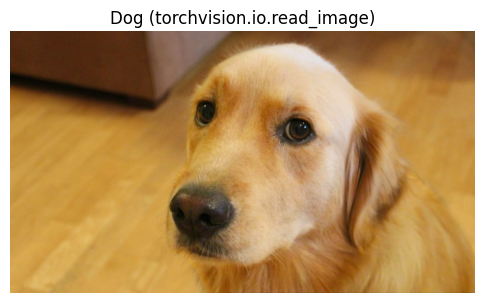

In [3]:
# Cell 3: torchvision으로 2D 이미지 로드 및 시각화
import torchvision

tsr_img = torchvision.io.read_image(dog_img_path)  # Tensor[C,H,W], dtype=uint8
print("Tensor shape (C,H,W):", tsr_img.shape, tsr_img.dtype)

plt.figure(figsize=(6,4))
plt.imshow(tsr_img.permute(1,2,0))  # (H,W,C)
plt.title("Dog (torchvision.io.read_image)")
plt.axis("off")
plt.show()


torchvision.io.read_image는 JPEG/PNG/GIF를

C,H,W 순서의 uint8 텐서로 읽어 오며, 시각화를 위해서는

H,W,C로 차원 순서를 바꿔야 한다.

이 접근은 바로 PyTorch 텐서를 반환하므로 이후 스택/정규화/배치 처리에 연계하기 쉽다.

/tmp/ipython-input-1616717275.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread(dog_img_path)  # ndarray[H,W,C]


Array shape (H,W,C): (720, 1280, 3) uint8


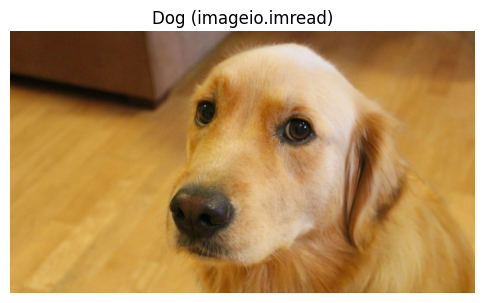

Converted Tensor shape: torch.Size([3, 720, 1280]) torch.uint8


In [4]:
# Cell 4: imageio로 2D 이미지 로드 및 시각화
img_arr = imageio.imread(dog_img_path)  # ndarray[H,W,C]
print("Array shape (H,W,C):", img_arr.shape, img_arr.dtype)

plt.figure(figsize=(6,4))
plt.imshow(img_arr)
plt.title("Dog (imageio.imread)")
plt.axis("off")
plt.show()

# 텐서로 변환이 필요하다면 (옵션)
tsr_from_arr = torch.from_numpy(img_arr)  # (H,W,C), dtype=uint8
tsr_from_arr = tsr_from_arr.permute(2,0,1)  # (C,H,W)
print("Converted Tensor shape:", tsr_from_arr.shape, tsr_from_arr.dtype)


imageio.imread는 NumPy 배열을

H,W,C 순서로 반환하므로 별도 차원 변환 없이 즉시 시각화 가능하다.

텐서 파이프라인과 혼용할 때는 torch.from_numpy를 통해 텐서로 변환해 사용할 수 있다.

Num images: 3 e.g., ['cat1.png', 'cat2.png', 'cat3.png']
Batch shape: torch.Size([3, 3, 256, 256]) torch.uint8


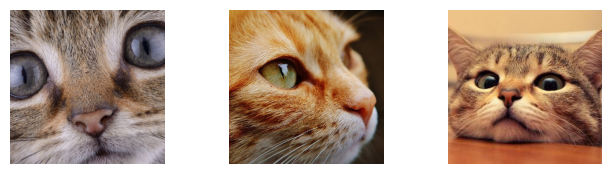

In [6]:
# Cell 5: 폴더의 PNG 이미지를 한 번에 배치로 적재
import os
from glob import glob

data_dir = cats_dir
# PNG 필터링(필요시 모든 확장자를 허용해도 무방)
filenames = sorted([name for name in os.listdir(data_dir) if os.path.splitext(name)[-1].lower() == ".png"])
print("Num images:", len(filenames), "e.g.,", filenames[:3])

# 개별 크기가 다를 수 있으므로, 통일된 크기로 로드하고 싶다면 torchvision.io.decode_image와
# torchvision.transforms.functional.resize 등을 결합한다.
# 여기서는 원문 흐름처럼 256x256, RGB 3채널의 uint8 텐서 배치를 만든다.
import torchvision.transforms.functional as TF

batch_size = len(filenames)
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

for i, filename in enumerate(filenames):
    img = torchvision.io.read_image(os.path.join(data_dir, filename))  # (C,H,W), uint8
    # 채널 수 보정(필요 시): 흑백이면 RGB로 변환
    if img.shape == 1:
        img = img.expand(3, img.shape[1], img.shape[2])
    # 크기 보정: 256x256
    img_resized = TF.resize(img, size=[256, 256], antialias=True)
    batch[i] = img_resized

print("Batch shape:", batch.shape, batch.dtype)

# 배치 시각화(앞의 3장)
fig = plt.figure(figsize=(8, 2))
for i in range(min(3, batch.shape[0])): # Corrected line: compare with batch size
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(batch[i].permute(1,2,0))
    ax.axis("off")
plt.show()

폴더 내 파일명을 수집해 미리 크기·dtype이 맞는 빈 텐서를 만들고, 반복문으로 각 이미지를 해당 인덱스에 채워 배치를 구성한다.

시각화를 위해서는 배치의 i번째 이미지를

H,W,C 순서로 변환한 뒤 imshow를 호출한다.

In [7]:
# Cell 6: 정규화 예시(0-1 스케일, 채널별 표준화)
batch_f01 = batch.float() / 255.0  # [0,1]
print("batch_f01:", batch_f01.shape, batch_f01.dtype, batch_f01.min().item(), batch_f01.max().item())

# 배치 전체 기준 채널별 평균/표준편차
# (N, C, H, W) -> 평균/표준편차를 (C,)로 계산
mean = batch_f01.mean(dim=(0,2,3))
std = batch_f01.std(dim=(0,2,3)).clamp(min=1e-6)
batch_std = (batch_f01 - mean[None, :, None, None]) / std[None, :, None, None]
print("Per-channel mean:", mean, "std:", std)

# 이미지별 채널 표준화가 필요하다면 아래처럼 축을 조정
# mean_img = batch_f01.mean(dim=(2,3), keepdim=True)
# std_img  = batch_f01.std(dim=(2,3), keepdim=True).clamp(min=1e-6)
# batch_std_img = (batch_f01 - mean_img) / std_img


batch_f01: torch.Size([3, 3, 256, 256]) torch.float32 0.0 1.0
Per-channel mean: tensor([0.5799, 0.4493, 0.3554]) std: tensor([0.2212, 0.2068, 0.1931])


신경망 입력은 일반적으로 float로 변환 후 범위 스케일링 또는 채널별 평균·표준편차 표준화가 효과적이다.

예시는 배치 전체 기준 채널별 표준화를 보여주며, 필요하면 이미지별 표준화로 변경할 수 있다.

In [23]:
# Cell 7: DICOM 폴더에서 3D 볼륨 읽기
vol_arr = imageio.volread(dicom_dir, "DICOM")  # shape: (D, H, W) 또는 (H, W, D) 구현에 따라 다름
print("Raw volume shape:", vol_arr.shape, vol_arr.dtype)

# imageio DICOM은 일반적으로 (num_slices, height, width) 순서를 반환
# 필요 시 축 확인/교정
if vol_arr.ndim == 3:
    if vol_arr.shape[0] < vol_arr.shape[-1]: # Corrected comparison
        # (D,H,W)로 가정
        D, H, W = vol_arr.shape
        vol_dhw = vol_arr
    else:
        # (H,W,D) 케이스를 (D,H,W)로 변환
        H, W, D = vol_arr.shape
        vol_dhw = np.transpose(vol_arr, (2,0,1))
else:
    raise ValueError(f"Unexpected volume ndim: {vol_arr.ndim}")

print("Volume (D,H,W):", vol_dhw.shape)

# 텐서 변환 및 float 변환, 채널 차원 추가 -> (1, D, H, W)
vol = torch.from_numpy(vol_dhw).float().unsqueeze(0)
print("Tensor volume shape (C,D,H,W):", vol.shape, vol.dtype)

Reading DICOM (examining files): 1/99 files (1.0%)99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 66/99  (66.7%)99/99  (100.0%)
Raw volume shape: (99, 512, 512) int16
Volume (D,H,W): (99, 512, 512)
Tensor volume shape (C,D,H,W): torch.Size([1, 99, 512, 512]) torch.float32


imageio.volread를 폴더 경로와 함께 호출하면 동일 시리즈의 DICOM 슬라이스를 자동으로 정렬·스택해 3D 배열을 반환한다.

이후 torch.from_numpy로 텐서로 변환하고, 단일 채널(volumetric grayscale)로 가정해 채널 차원을 앞쪽에 추가해

1,D,H,W 형태로 맞춘다.

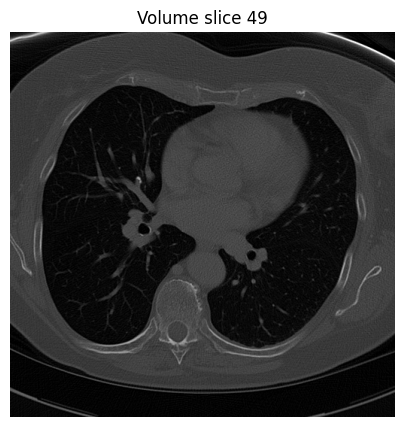

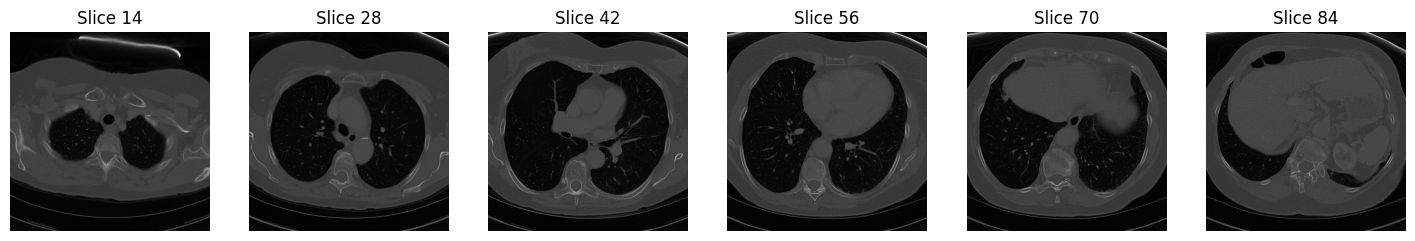

In [24]:
# Cell 8: 볼륨 단면 시각화
C, D, H, W = vol.shape

# 단일 슬라이스
idx = D // 2
plt.figure(figsize=(5,5))
plt.imshow(vol[0, idx].numpy(), cmap="gray")
plt.title(f"Volume slice {idx}")
plt.axis("off")
plt.show()

# 여러 슬라이스(등간격)
num_show = 6
step = max(1, D // (num_show+1))
fig = plt.figure(figsize=(18,3))
for i in range(num_show):
    ax = fig.add_subplot(1, num_show, i+1)
    si = (i+1)*step
    ax.imshow(vol[0, si].numpy(), cmap="gray")
    ax.set_title(f"Slice {si}")
    ax.axis("off")
plt.show()


임의의 슬라이스 인덱스를 선택해 단면을 시각화하거나, 일정 간격으로 여러 장을 나란히 그려 볼 수 있다.

의료 영상은 윈도/레벨(예: CT에서 HU 범위)을 조정해야 시인성이 좋아지는 경우가 많으므로 imshow의 vmin/vmax를 적절히 지정한다.